In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.preprocessing import StandardScaler


from xgboost import XGBClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

---

## Split the Data into Training and Testing Sets

### Step 1: Read the `lending_data.csv` data from the `Resources` folder into a Pandas DataFrame.

In [2]:
# Read the CSV file from the Resources folder into a Pandas DataFrame
file = "Resources/lending_data.csv"
df = pd.read_csv(file)

# Review the DataFrame
print(df.shape)
df.head()

(77536, 8)


,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt,loan_status
0,10700.0,7.672,52800,0.431818,5,1,22800,0
1,8400.0,6.692,43600,0.311927,3,0,13600,0
2,9000.0,6.963,46100,0.349241,3,0,16100,0
3,10700.0,7.664,52700,0.430740,5,1,22700,0
4,10800.0,7.698,53000,0.433962,5,1,23000,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77536 entries, 0 to 77535
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   loan_size         77536 non-null  float64
 1   interest_rate     77536 non-null  float64
 2   borrower_income   77536 non-null  int64  
 3   debt_to_income    77536 non-null  float64
 4   num_of_accounts   77536 non-null  int64  
 5   derogatory_marks  77536 non-null  int64  
 6   total_debt        77536 non-null  int64  
 7   loan_status       77536 non-null  int64  
dtypes: float64(3), int64(5)
memory usage: 4.7 MB


### Step 2: Create the labels set (`y`)  from the “loan_status” column, and then create the features (`X`) DataFrame from the remaining columns.

In [4]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = df.loan_status

# Separate the X variable, the features
x = df.drop(columns = ["loan_status"])

# Scaling needed
scaler = StandardScaler()

# fit
scaler.fit(x)

# predict/transform
scaled_data = scaler.transform(x)
df_scaled = pd.DataFrame(scaled_data, columns=x.columns)

X = df_scaled


In [5]:
# Review the y variable Series
y.value_counts()

loan_status
0    75036
1     2500
Name: count, dtype: int64

In [6]:
# Review the X variable DataFrame
X.head()

,loan_size,interest_rate,borrower_income,debt_to_income,num_of_accounts,derogatory_marks,total_debt
0,0.427304,0.426837,0.427404,0.668571,0.616143,1.043996,0.427404
1,-0.671487,-0.674918,-0.671552,-0.802166,-0.434049,-0.673973,-0.671552
2,-0.384846,-0.370249,-0.372922,-0.344424,-0.434049,-0.673973,-0.372922
3,0.427304,0.417844,0.415459,0.655346,0.616143,1.043996,0.415459
4,0.475078,0.456068,0.451295,0.694873,0.616143,1.043996,0.451295


### Step 3: Split the data into training and testing datasets by using `train_test_split`.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(58152, 7) (19384, 7)


---

## Create a Logistic Regression Model with the Original Data

In [8]:
# Define a function to utilize for multiple Machine Learning models
# Function borrowed from in calss examples
def doClassification(model, X_train, X_test, y_train, y_test):
    # Fit the model
    model.fit(X_train, y_train)
    
    # Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

###  Step 1: Fit a logistic regression model by using the training data (`X_train` and `y_train`).

TRAIN METRICS
    Confusion Matrix: 
    [[55957   320]
 [   33  1842]]
    
    AUC: 0.9943324010400933

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.98      0.91      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.95     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18669    90]
 [   12   613]]
    
    AUC: 0.9965558931712777

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.98      0.92       625

    accuracy                           0.99     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      0.99      0.99     19384

    


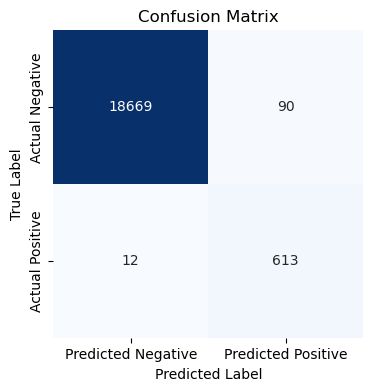

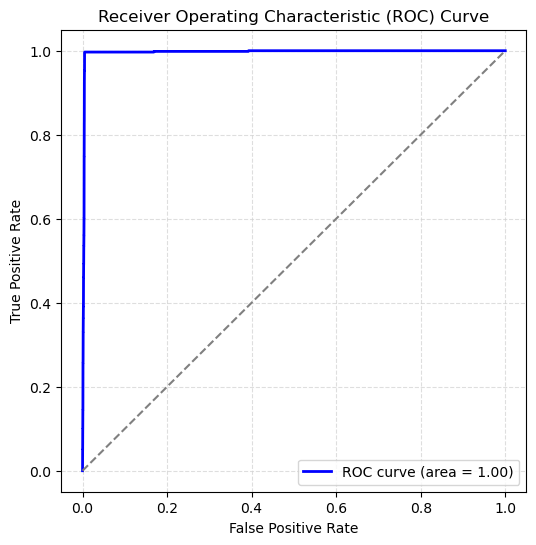

In [9]:
# logistic regression

lr = LogisticRegression()

# Do Machine Learning
doClassification(lr, X_train, X_test, y_train, y_test)

### Step 2: Save the predictions on the testing data labels by using the testing feature data (`X_test`) and the fitted model.

In [10]:
# Saving logistic regression predictions
lr_preds = lr.predict(X_test)

### Comparing Logistic Regression to Other ML Models


TRAIN METRICS
    Confusion Matrix: 
    [[56224    53]
 [  102  1773]]
    
    AUC: 0.9998578886578886

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.97      0.95      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.98      0.97      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18684    75]
 [  119   506]]
    
    AUC: 0.9398868169945094

    Classification Report:
                  precision    recall  f1-score   support

           0       0.99      1.00      0.99     18759
           1       0.87      0.81      0.84       625

    accuracy                           0.99     19384
   macro avg       0.93      0.90      0.92     19384
weighted avg       0.99      0.99      0.99     19384

    


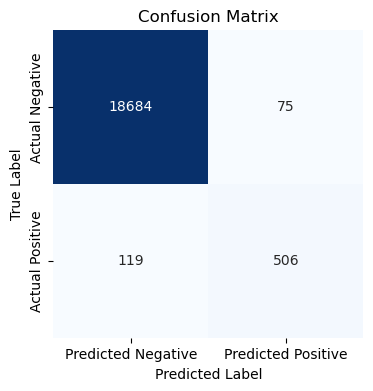

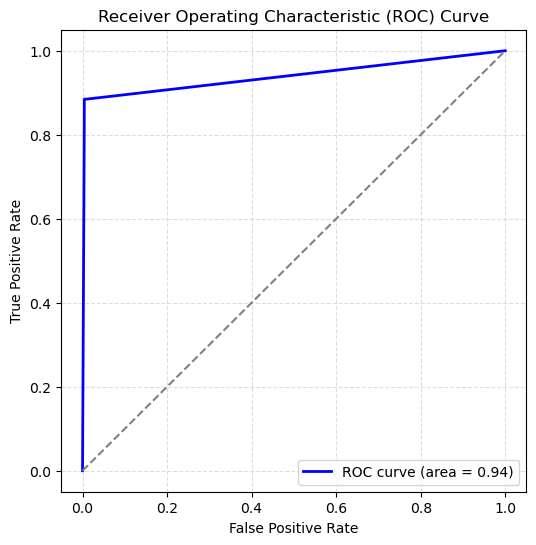

In [11]:
# Decision Tree
dt = DecisionTreeClassifier()

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[56151   126]
 [   29  1846]]
    
    AUC: 0.9998226249918557

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.94      0.98      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.97      0.99      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18681    78]
 [   80   545]]
    
    AUC: 0.9958317607548376

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.87      0.87       625

    accuracy                           0.99     19384
   macro avg       0.94      0.93      0.93     19384
weighted avg       0.99      0.99      0.99     19384

    


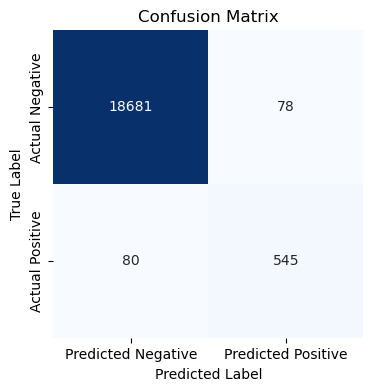

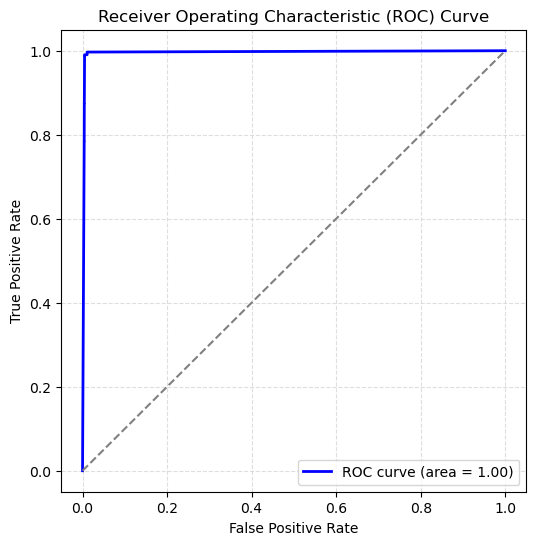

In [12]:
# Random Forest
rf = RandomForestClassifier()

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[55949   328]
 [   12  1863]]
    
    AUC: 0.9957361527207681

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18669    90]
 [    3   622]]
    
    AUC: 0.9953638466869237

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      1.00      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      1.00      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


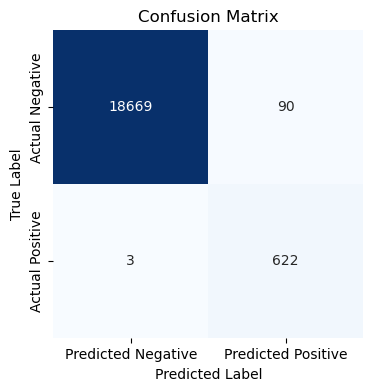

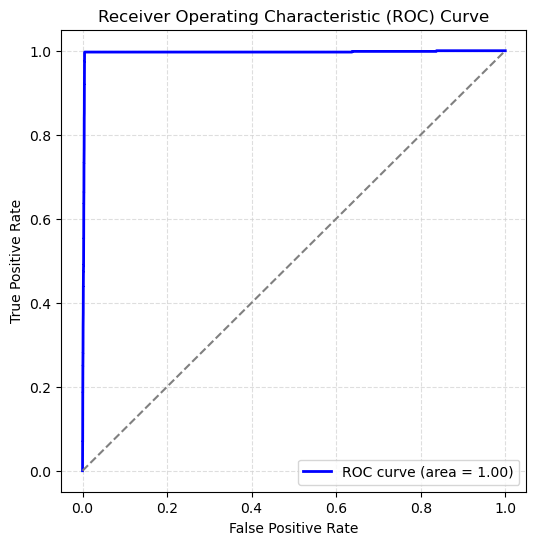

In [13]:
# Support Vector Classifier
svc = SVC(probability=True)

# Do Machine Learning
doClassification(svc, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[55949   328]
 [   12  1863]]
    
    AUC: 0.9973291966522736

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18669    90]
 [    3   622]]
    
    AUC: 0.9958933418625725

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      1.00      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      1.00      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


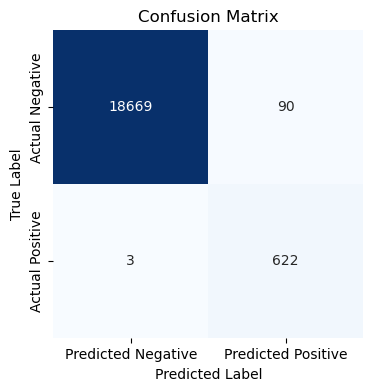

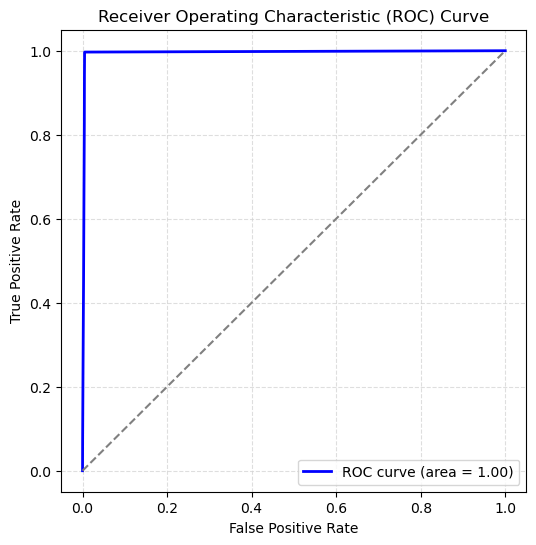

In [14]:
# K nearest neighbors
knn = KNeighborsClassifier(n_neighbors=25)

# Do Machine Learning
doClassification(knn, X_train, X_test, y_train, y_test)

In [22]:
# Saving the predictions of the KNN model
knn_preds = knn.predict(X_test)

TRAIN METRICS
    Confusion Matrix: 
    [[56224    53]
 [  102  1773]]
    
    AUC: 0.9998578886578886

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     56277
           1       0.97      0.95      0.96      1875

    accuracy                           1.00     58152
   macro avg       0.98      0.97      0.98     58152
weighted avg       1.00      1.00      1.00     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18683    76]
 [  112   513]]
    
    AUC: 0.9614474972013434

    Classification Report:
                  precision    recall  f1-score   support

           0       0.99      1.00      0.99     18759
           1       0.87      0.82      0.85       625

    accuracy                           0.99     19384
   macro avg       0.93      0.91      0.92     19384
weighted avg       0.99      0.99      0.99     19384

    


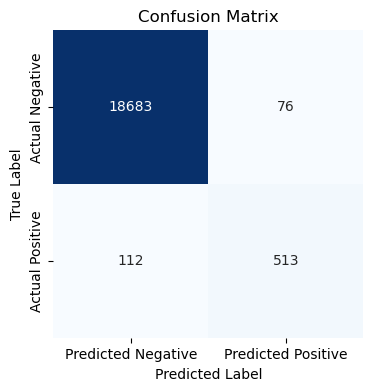

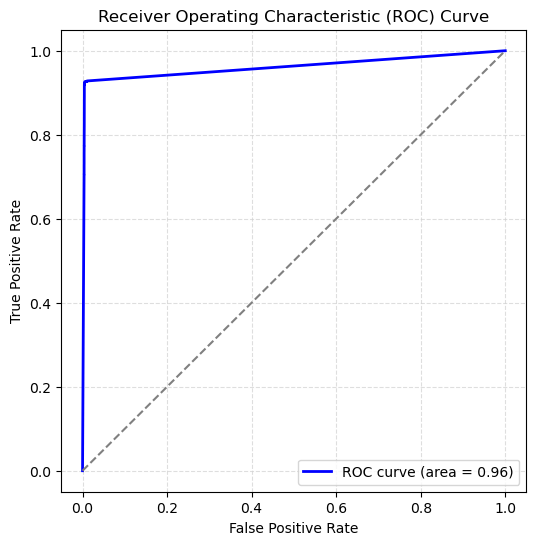

In [15]:
# Extra Trees
et = ExtraTreesClassifier()

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[55954   323]
 [   15  1860]]
    
    AUC: 0.9970676854369163

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       0.99      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18669    90]
 [    5   620]]
    
    AUC: 0.9964305986459833

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


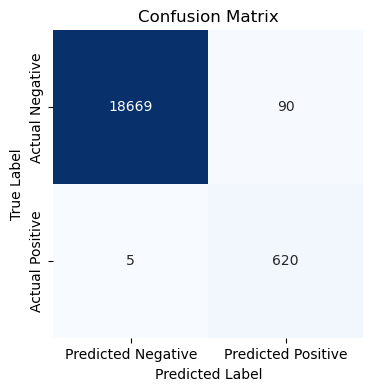

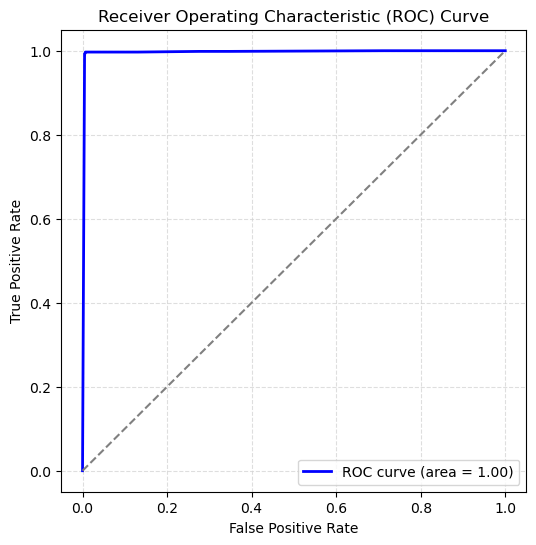

In [16]:
# Ada Boost
ada = AdaBoostClassifier()

# Do Machine Learning
doClassification(ada, X_train, X_test, y_train, y_test)

In [20]:
# Saving off the predictions of the Ada boosted model
ada_preds = ada.predict(X_test)

TRAIN METRICS
    Confusion Matrix: 
    [[55965   312]
 [   10  1865]]
    
    AUC: 0.9983701855701855

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.86      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       1.00      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18668    91]
 [    6   619]]
    
    AUC: 0.9952849938696093

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           0.99     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      0.99      1.00     19384

    


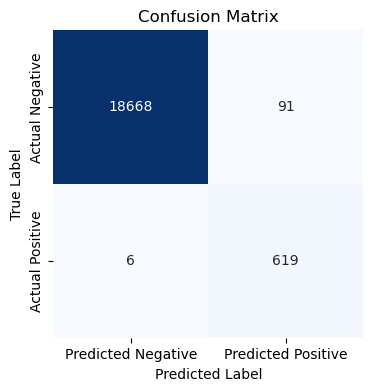

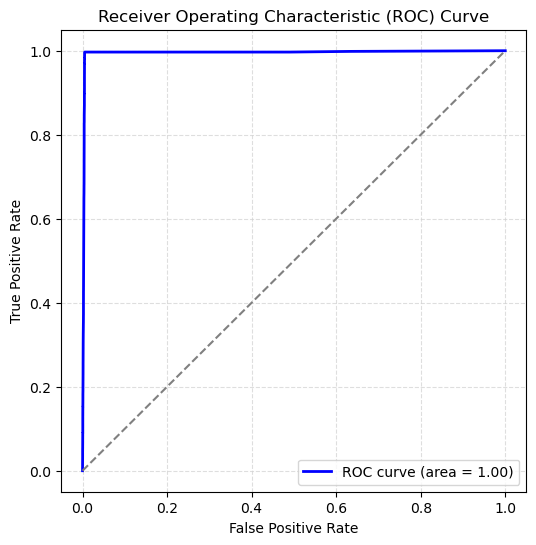

In [17]:
# Gradient Boosted
gb = GradientBoostingClassifier(random_state=42)

# Do Machine Learning
doClassification(gb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[55954   323]
 [   13  1862]]
    
    AUC: 0.997842699504238

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      0.99      1.00     56277
           1       0.85      0.99      0.92      1875

    accuracy                           0.99     58152
   macro avg       0.93      0.99      0.96     58152
weighted avg       1.00      0.99      0.99     58152

    
TEST METRICS
    Confusion Matrix: 
    [[18669    90]
 [    4   621]]
    
    AUC: 0.9956511114664961

    Classification Report:
                  precision    recall  f1-score   support

           0       1.00      1.00      1.00     18759
           1       0.87      0.99      0.93       625

    accuracy                           1.00     19384
   macro avg       0.94      0.99      0.96     19384
weighted avg       1.00      1.00      1.00     19384

    


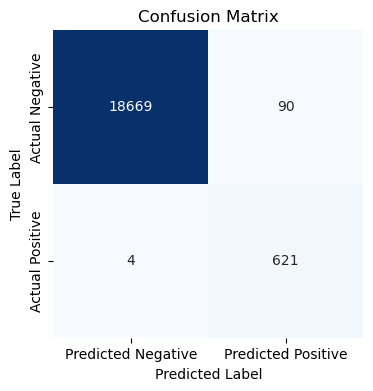

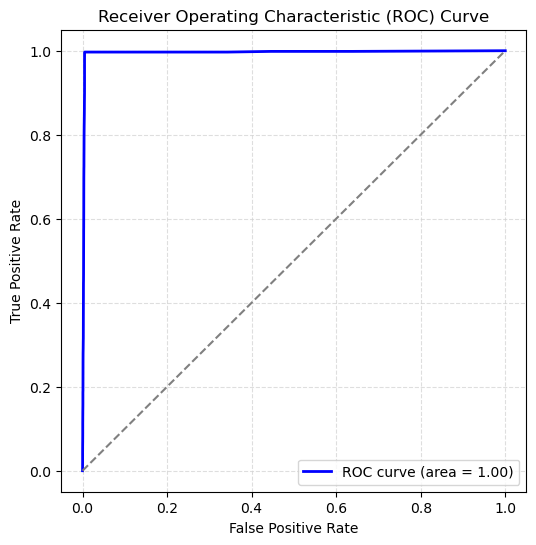

In [18]:
# X gradient boost

xgb = XGBClassifier(random_state=42)

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

### Step 4: Answer the following question.

**Question:** How well does the logistic regression model predict both the `0` (healthy loan) and `1` (high-risk loan) labels?

**Answer:** The logistic regression performs fairly well with a an AUC score of 0.9966, 90 instances of type I error, and 12 instances of type II error. Given the nature of the problem, a priority should be to minimize type II error. 

2 other models worth consideration are the K Nearest Neighbors model and and the AdaBoost algorithm. These provide comparable AUC scores at .9958 and .9964 respectively. Each produces a slightly lower instance of type II errors with the same number of type I errors. 

The analyst's selection for this data would be the AdaBoost model. 

In [ ]:
# The full report for this project is included in the ReadMe. 

---